tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf
60000 train samples
10000 test samples
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 33s 683us/step - loss: 0.1849 - accuracy: 0.9420 - val_loss: 0.0653 - val_accuracy: 0.9801
Epoch 2/20
48000/48000 [==============================] - 32s 672us/step - loss: 0.0488 - accuracy: 0.9841 - val_loss: 0.0508 - val_accuracy: 0.9851
Epoch 3/20
48000/48000 [==============================] - 32s 659us/step - loss: 0.0321 - accuracy: 0.9897 - val_loss: 0.0438 - val_accuracy: 0.9874
Epoch 4/20
48000/48000 [==============================] - 32s 660us/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.0336 - val_accuracy: 0.9896
Epoch 5/20
48000/48000 [==============================] - 30s 625us/step - loss: 0.0157 - accuracy: 0.9949 - val_loss: 0.0394 - val_accuracy: 0.9887
Epoch 6/20
48000/48000 [==============================] - 31s 638us/step - loss: 0.0124 - accuracy: 0.9960 -

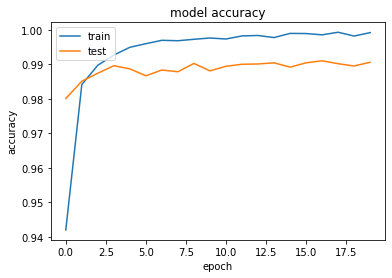

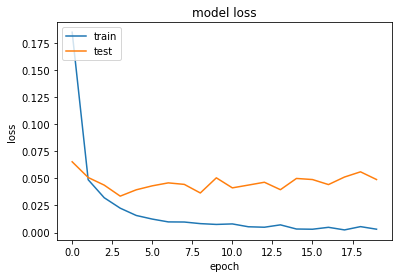

In [2]:
# import the necessary packages
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np

import tensorflow as tf

tf.test.is_gpu_available()

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
#import segmentation_models as sm

import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

np.random.seed(1671)  # for reproducibility

#define the convnet 
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()
		# CONV => RELU => POOL
		model.add(Conv2D(20, kernel_size=5, padding="same",
			input_shape=input_shape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# CONV => RELU => POOL
		model.add(Conv2D(50, kernel_size=5, padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))
		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))
 
		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

# network and training
NB_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = 28, 28 # input image dimensions
NB_CLASSES = 10  # number of outputs = number of digits
INPUT_SHAPE = (1, IMG_ROWS, IMG_COLS)

# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#K.set_image_dim_ordering("th")
#K.image_data_format()
K.set_image_data_format('channels_first')

# consider them as float and normalize
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 
X_test /= 255  

# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# initialize the optimizer and model
model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

score = model.evaluate(X_test, y_test, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
